In [ ]:
!git clone https://github.com/mohammadataei93/Neural-machine-translation-with-attention.git
!pip install faker

In [4]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import os
os.chdir('/content/Neural-machine-translation-with-attention')

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

<a name='1-1'></a>
Dataset

In [5]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 18077.28it/s]


In [6]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

In [7]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [8]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [9]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') 
dotor = Dot(axes = 1)

In [10]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a,s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas,a])
    return context

In [11]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # Please do not modify this global variable.
output_layer = Dense(len(machine_vocab), activation=softmax)

In [12]:
def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    outputs = []
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    return model

In [13]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 30, 64)       17920       ['input_1[0][0]']                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 30, 64)       0           ['s0[0][0]',                     
                                                                  'lstm[0][0]',               

**Expected Output**:

Here is the summary you should see
<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64) 
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>


In [ ]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01) # Adam(...) 
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [16]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [ ]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

In [19]:
model.load_weights('models/model.h5')

results on new examples.

In [20]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

source: 3 May 1979
output: 1979-05-33 

source: 5 April 09
output: 2009-04-05 

source: 21th of August 2016
output: 2016-08-20 

source: Tue 10 Jul 2007
output: 2007-07-10 

source: Saturday May 9 2018
output: 2018-05-09 

source: March 3 2001
output: 2001-03-03 

source: March 3rd 2001
output: 2001-03-03 

source: 1 March 2001
output: 2001-03-01 



<a name='3'></a>
Visualizing Attention

<Figure size 432x288 with 0 Axes>

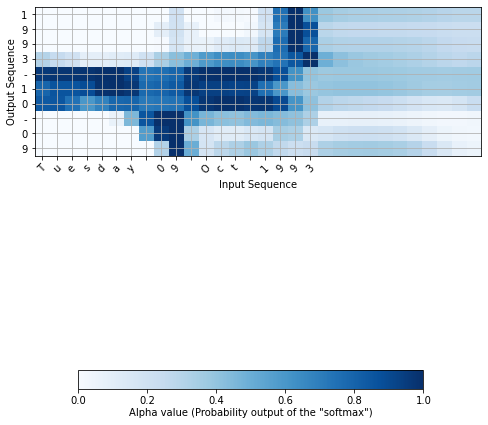

In [21]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);